In [1]:
import os
from pylab import *
from pysb.core import *
from pysb.bng import *
from pysb.integrate import *
import matplotlib.pyplot as plt
import numpy as np
from pysb.util import alias_model_components
from pysb.simulator import CupSodaSimulator
from pysb.simulator import ScipyOdeSimulator
from pysb.simulator.bng import BngSimulator
import sys
sys.path.append('../')
sys.path.append('../../../')
sys.path.append('/home/ildefog/main/Projects/NERM/')
sys.path.append('/home/ildefog/main/Projects/NERM/params_testing/')
from model_files.nerm_pvals_inits import model 
import pandas as pd
from scipy import stats
from pysb.simulator import SimulationResult
import logging
import os
from pysb.logging import setup_logger
from pysb.simulator.cupsoda import CupSodaSimulator
from pysb.simulator.scipyode import ScipyOdeSimulator
from sensitivity_analysis4 import InitialsSensitivity
from pysb.util import update_param_vals
from scipy.stats import norm,uniform, halfnorm
from pysb.tools.sensitivity_analysis import PairwiseSensitivity
os.environ['OMP_NUM_THREADS'] = '1'
from scipy.optimize import curve_fit

In [ ]:
m1 = np.load('../../params_testing/necro_pars10k_mode1_5720_mod.npy')
m2 = np.load('../../params_testing/necro_pars10k_mode2_5720_mod.npy')
m3 = np.load('../../params_testing/necro_pars10k_mode3_5720_mod.npy')
m4 = np.load('../../params_testing/necro_pars10k_mode4_5720_mod.npy')

In [ ]:
t = np.linspace(0,1440,1441)
m = model.components

In [ ]:
solverwtm1 = ScipyOdeSimulator(model, tspan=t, verbose = True)
mode1wtm1  = solverwtm1.run(param_values=m2[7], num_processors = 20)
mode1df_wtm1 = mode1wtm1.dataframe

In [ ]:
fig, ax = plt.subplots()
# for n in range(len(mode1_100)):
plt.plot(t/60, mode1df_wtm1.loc[:]['MLKLa_obs'].iloc[:]/5544, lw=1.5, 
             zorder = 1)
# colormap = plt.cm.Reds #nipy_spectral, Set1,Paired   
# colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]
# for i,j in enumerate(ax.lines):
#     j.set_color(colors[i])
# ax1.legend(loc=2)    
plt.xlabel("Time (hours)", fontsize=15)
plt.ylabel("pMLKL (normalized)", fontsize=15)
plt.xlim(xmin = 0, xmax = 16)
plt.ylim(ymin = 0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
ax.set_xticks([0, 5, 10, 15, 20, 24])
ax.grid(False)
plt.tight_layout()
# plt.savefig('pmlkl_allpars_clus0_tnf100_noframe.pdf')
plt.show() 

In [ ]:
with open('necro_5720mode2_paramk7tnf100.txt', 'w') as f:
   for p, v in zip(model.parameters, mode1wtm1.param_values[0]):
       f.write('{},{:e}\n'.format(p.name, v))

2022-01-13 20:45:55.652 - pysb - INFO - Logging started on PySB version 1.11.0
2022-01-13 20:45:55.654 - pysb - INFO - Log entry time offset from UTC: -6.00 hours
2022-01-13 20:45:57.067 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals_inits] Simulation(s) started


2022-01-13 20:45:57.276 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals_inits] All simulation(s) complete
2022-01-13 20:45:57.326 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals_inits] Simulation(s) started
2022-01-13 20:47:53.712 - pysb.simulator.scipyode - INFO - [model_files.nerm_pvals_inits] All simulation(s) complete


(14, 325)


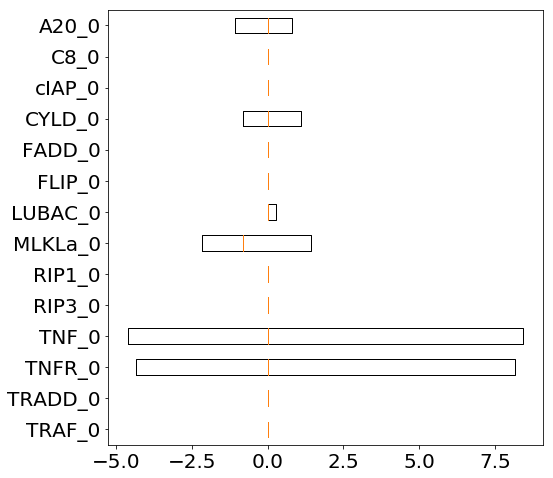

TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e')

In [2]:
def update_param_vals(model, newvals):
    """update the values of model parameters with the values from a dict.
    the keys in the dict must match the parameter names
    """
    update = []
    noupdate = []
    for i in model.parameters:
        if i.name in newvals:
            i.value = newvals[i.name]
            update.append(i.name)
        else:
            noupdate.append(i.name)
    return update, noupdate
setup_logger(logging.INFO, file_output='necroclusters2large_5720.log', console_output=True)
observable = 'MLKLa_obs'

tspan = np.array([30, 90, 270, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440, 1560, 1680, 1800])

def likelihood(mlkl_traj):
    #Here we fit a spline to find where we get 50% release of MOMP reporter
#     ysim_mlkl_norm = mlkl_traj/np.nanmax(mlkl_traj)
#     threshold = 2772
    threshold = 2772
    st, sc, sk = scipy.interpolate.splrep(tspan, mlkl_traj)
    tspan2 = np.linspace(tspan[0], tspan[-1], 1000)
    mlkl_traj2 = scipy.interpolate.splev(tspan2, (st, sc, sk))
    for i in range(len(mlkl_traj2)):
        if mlkl_traj2[i] > threshold:
            td = tspan2[i]
            break 
        if i == len(mlkl_traj2)-1:   
            td = np.nan

    return td
# def likelihood(mlkl_traj):
#     #Here we fit a spline to find where we get 50% release of MOMP reporter
#     ysim_mlkl_norm = mlkl_traj / 2772 #np.nanmax(mlkl_traj)
#     st, sc, sk = scipy.interpolate.splrep(tspan, ysim_mlkl_norm)
#     try:
#         t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
#         t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
#     except IndexError:
#         t10 = 0
#         t90 = 0

#     # time of death  = halfway point between 10 and 90%
#     td = (t10 + t90) / 2

#     return td

def run():
    vals = np.linspace(0.3, 1.7, 5)
    new_params2 = pd.read_csv('necro_5720mode2_paramk7tnf100.txt',
        index_col=0, names=['name', 'value']).to_dict('dict')['value']

    update_param_vals(model, new_params2)

    use_cupsoda = False
    if use_cupsoda:
        integrator_opt = {'rtol': 1e-6, 'atol': 1e-6, 'max_steps': 20000,
                          'memory_usage': 'global', 'vol': 1e-19}
        solver = CupSodaSimulator(model, t, verbose=True, gpu=0,
                                  integrator_options=integrator_opt,
                                  )
    else:
        integrator_opt_scipy = {'rtol': 1e-6, 'atol': 1e-6, 'mxstep': 20000}
        solver = ScipyOdeSimulator(model, tspan=tspan, integrator='lsoda',
                                   integrator_options=integrator_opt_scipy)
    sens = InitialsSensitivity(
        solver,
        values_to_sample=vals,
        observable=observable,
        objective_function=likelihood, sens_type='initials')  #

    sens.run('output_{}', out_dir=out_dir)
    sens.create_heatplot(save_name='mode2k7heatinew', out_dir=out_dir)
    InitialsSensitivity.create_boxplot(sens, save_name='mode2k7boxinew', out_dir=out_dir, show = True)
#     sens.create_boxplot(save_name='mode1k12boxpnew', out_dir=out_dir)
#     sens.create_individual_pairwise_plots(save_name='mode1k12inew', out_dir=out_dir)

if __name__ == '__main__':
#     model_v = 'necro'
#     # all parameter fits from pso
# #     p_set = 'all_params_24_part_200_iter_2_bound_0.1_speed.csv'
#     params = pd.read_csv('necro_5720mode1mid_paramk12tnf100_test.txt',
#         index_col=0, names=['name', 'value']).to_dict('dict')['value']
# #     print(len(params))
#     # how many sens analysis to run
#     n_sets = 1

#     # spacing for sens analysis
#     vals = np.linspace(.6, 1.4, 5)

#     solver = ScipyOdeSimulator(model, tspan, integrator='lsoda',
#                                verbose=True,
#                                use_analytic_jacobian=True,
#                                compiler='cython',
#                                integrator_options={"rtol": 1e-6,
#                                                    "atol": 1e-6})
#     # The observable of the model
#     observable = 'MLKLa_obs'
#     sens = InitialsSensitivity(
#         values_to_sample=vals,
#         observable=observable,
#         objective_function=likelihood,
#         solver=solver,sens_type = 'initials'
#     )
    out_dir = 'mode2_initials_k7_70perc'
#     out_dir = p_set.split(',')[0]
#     if not os.path.exists(out_dir):
#         os.mkdir(out_dir)
    run()
#     process()
#     load()